In [2]:
import pandas as pd 
import matplotlib.pyplot as plt

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import unidecode
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
import re

In [3]:
df= pd.read_csv('train.csv')

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [17]:
df.shape

(159571, 9)

In [5]:
class_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [6]:
df['toxic_classification'] = df[class_columns].max(axis=1)

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_classification
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [8]:
df['toxic_classification'].value_counts()


toxic_classification
0    143346
1     16225
Name: count, dtype: int64

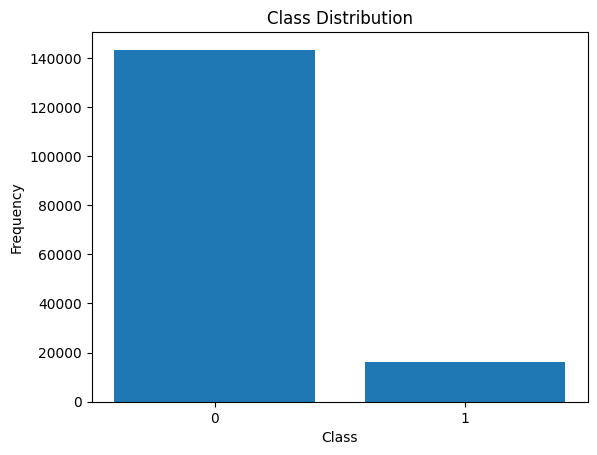

In [15]:
class_counts = df['toxic_classification'].value_counts()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')


plt.show()

In [16]:
df['comment_text'].head(10)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [9]:
#data cleaning, tokenization and stop words 
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove accents
    text = unidecode.unidecode(text)
    # Normalize numbers: Replace digits with a special token, e.g., "NUM"
    text = re.sub(r'\d+', 'NUM', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    #special characters 
    text = re.sub(r'[^\w\sáéíóúüñ¿¡]', '', text) 
    # Tokenize the text into words
    words = word_tokenize(text)
    # Define stop words for Spanish
    stop_words = set(stopwords.words('english'))
    # Remove stop words from the tokenized words
    words = [word for word in words if word not in stop_words]
    # Join the words back into a single string with spaces-
    return ' '.join(words)

df['cleaned_text'] = df['comment_text'].apply(preprocess_text)

In [10]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_classification,cleaned_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww matches background colour im seemingly st...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man im really trying edit war guy constant...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,cant make real suggestions improvement wondere...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,sir hero chance remember page thats


In [22]:
# TF-IDF Vectorization function and logistic_regression
def tfidf_vectorize(data, text_column):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data[text_column])
    return X, vectorizer

# Logistic Regression Classification function
def logistic_regression_classification(X, y):
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,) #random_state=42)
    
    # Train the classifier
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return accuracy, report, classifier

# Main function to tie everything together
def main_tfidf_log_reg(data, text_column):
    # TF-IDF Vectorization
    X, vectorizer = tfidf_vectorize(data, text_column)
    y = data['toxic_classification']

    # Classification
    accuracy, report, classifier = logistic_regression_classification(X, y)
    

    # Print class mapping
    class_mapping = classifier.classes_
    print(f'Class Mapping: {class_mapping}')
    
    # Output results
    print(f'Accuracy: {accuracy}')
    print(report)
    
    return vectorizer, classifier


vectorizer, classifier = main_tfidf_log_reg(df, 'cleaned_text')

Class Mapping: [0 1]
Accuracy: 0.9546294845683848
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     28734
           1       0.94      0.58      0.72      3181

    accuracy                           0.95     31915
   macro avg       0.95      0.79      0.85     31915
weighted avg       0.95      0.95      0.95     31915



c:\Users\anama\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Gradient boost

In [25]:
#Gradient boosting with td-idf
def gradient_boosting_classification(X, y):
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the classifier
    classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return accuracy, report, classifier

# Main function to tie everything together
def main_gradient_boosting(data, text_column):
    # Count Vectorization
    X, vectorizer = tfidf_vectorize(data, text_column)
    y = data['toxic_classification']
    
    # Classification
    accuracy, report, classifier = gradient_boosting_classification(X, y)
    
    # Output results
    print(f'Accuracy: {accuracy}')
    print(report)
    
    return vectorizer, classifier 

# Call the main function with gradient boosting
vectorizer, classifier = main_gradient_boosting(df, 'cleaned_text')

Accuracy: 0.9382422058593138
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     28671
           1       0.96      0.41      0.58      3244

    accuracy                           0.94     31915
   macro avg       0.95      0.70      0.77     31915
weighted avg       0.94      0.94      0.93     31915



### Random forest weighting class 

In [29]:
# Function for TF-IDF vectorization
def tfidf_vectorize_random_forest(data, text_column):
    vectorizer = TfidfVectorizer()  # Adjust max_features as needed
    X = vectorizer.fit_transform(data[text_column])
    return X, vectorizer

# Function for training Gradient Boosting Classifier with class weighting
def random_forest_classification(X, y):
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the classifier with class weighting
    classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return accuracy, report, classifier

# Main function to tie everything together
def main_random_forest(data, text_column):
    # TF-IDF Vectorization
    X, vectorizer = tfidf_vectorize_random_forest(data, text_column)
    y = data['toxic_classification']
    
    # Classification using Random Forest with class weighting
    accuracy, report, classifier = random_forest_classification(X, y)
    
    # Output results
    print(f'Accuracy: {accuracy}')
    print(report)
    
    return vectorizer, classifier

# Call the main function with Random Forest and class weighting
vectorizer, classifier = main_random_forest(df, 'cleaned_text')

Accuracy: 0.9371142096193013
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     28671
           1       0.84      0.47      0.60      3244

    accuracy                           0.94     31915
   macro avg       0.89      0.73      0.78     31915
weighted avg       0.93      0.94      0.93     31915



### Balance Random Forest

In [31]:
# Function for TF-IDF vectorization
def tfidf_vectorize_random_forest(data, text_column):
    vectorizer = TfidfVectorizer()  # Adjust parameters as needed
    X = vectorizer.fit_transform(data[text_column])
    return X, vectorizer

# Function for training Balanced Random Forest Classifier
def balanced_random_forest_classification(X, y):
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the classifier with Balanced Random Forest
    classifier = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return accuracy, report, classifier

# Main function to tie everything together
def main_balanced_random_forest(data, text_column):
    # TF-IDF Vectorization
    X, vectorizer = tfidf_vectorize_random_forest(data, text_column)
    y = data['toxic_classification']
    
    # Classification using Balanced Random Forest
    accuracy, report, classifier = balanced_random_forest_classification(X, y)
    
    # Output results
    print(f'Accuracy: {accuracy}')
    print(report)
    
    return vectorizer, classifier

# Example usage: Call the main function with Balanced Random Forest
vectorizer, classifier = main_balanced_random_forest(df, 'cleaned_text')

c:\Users\anama\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\anama\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


Accuracy: 0.8802130659564468
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     28671
           1       0.45      0.82      0.58      3244

    accuracy                           0.88     31915
   macro avg       0.71      0.85      0.76     31915
weighted avg       0.92      0.88      0.89     31915

